#### GROUP BY STEPS TAKEN TO FIX A ERROR
#### PASS TO O3 AND GET BETTER GROUPING LIKE DEBUGGING
Maybe add how many steps it took to fix the error

In [1]:
import os
import json
import glob
import re
from openai import OpenAI
import time
from pydantic import BaseModel
from dotenv import load_dotenv
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import re
from collections import defaultdict

In [3]:
load_dotenv()
client = OpenAI(
    # This is the default and can be omitted
    api_key=os.getenv("OPENAI_API_KEY")
)

In [4]:
def get_last_agent_file(folder_path):
    # Find all agent files in the folder
    agent_files = glob.glob(os.path.join(folder_path, "agent_*_*.json"))
    
    if not agent_files:
        return None
    
    # Extract agent numbers and find the highest one
    max_agent_num = 0
    max_agent_file = None
    
    for file in agent_files:
        # Extract the number from filename using regex
        match = re.search(r"agent_(\d+)_\d+\.json", file)
        if match:
            agent_num = int(match.group(1))
            if agent_num > max_agent_num:
                max_agent_num = agent_num
                max_agent_file = file
    
    return max_agent_file

def extract_history_steps(file_path):
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
            
        # Extract history_steps without observation field
        history_steps = data.get('history_steps', [])
        
        # Remove observation field from each step
        for step in history_steps:
            if 'observation' in step:
                del step['observation']

            if 'action' in step and isinstance(step['action'], dict):
                if 'Research Plan and Status' in step['action']:
                    del step['action']['Research Plan and Status']
                if 'Fact Check' in step['action']:
                    del step['action']['Fact Check']
                
        return history_steps
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def extract_task_name_and_id(folder_path):
    # Split the path into components
    parts = folder_path.split(os.sep)
    
    # Look for task name and run ID in the path
    task_name = None
    run_id = None
    
    for i, part in enumerate(parts):
        if i < len(parts) - 2 and parts[i+2].startswith('0'):  # Assuming run IDs start with numbers
            task_name = part
            run_id = parts[i+2]
            break
    
    return task_name, run_id

def process_all_folders(base_path, output_base):
    # Walk through directory structure
    for root, dirs, files in os.walk(base_path):
        # Check if this folder contains agent files
        agent_files = [f for f in files if f.startswith("agent_") and f.endswith(".json")]
        if agent_files:
            last_agent = get_last_agent_file(root)
            if last_agent:
                history = extract_history_steps(last_agent)
                if history:
                    # Extract task name and run ID from the folder path
                    task_name, run_id = extract_task_name_and_id(root)
                    
                    if task_name and run_id:
                        # Create output directory
                        output_dir = os.path.join(output_base, task_name, run_id)
                        os.makedirs(output_dir, exist_ok=True)
                        
                        # Save the extracted history
                        output_file = os.path.join(output_dir, "output.json")
                        with open(output_file, 'w') as f:
                            json.dump(history, f, indent=2)
                        
                        print(f"Extracted history from {root} saved to {output_file}")
                    else:
                        print(f"Could not determine task name and run ID for {root}")

In [4]:
base_directory = "data"
output_directory = "Steps"

# Create the base output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Process all folders
process_all_folders(base_directory, output_directory)

Extracted history from data/product-recommendation/gemini-exp-1206/0224204752_3547146/agent_log saved to Steps/product-recommendation/0224204752_3547146/output.json
Extracted history from data/product-recommendation/gemini-exp-1206/0224185433_2509699/agent_log saved to Steps/product-recommendation/0224185433_2509699/output.json
Extracted history from data/product-recommendation/gemini-exp-1206/0224204536_2561078/agent_log saved to Steps/product-recommendation/0224204536_2561078/output.json
Extracted history from data/product-recommendation/gemini-exp-1206/0224185433_896695/agent_log saved to Steps/product-recommendation/0224185433_896695/output.json
Extracted history from data/product-recommendation/gemini-exp-1206/0224185429_3486840/agent_log saved to Steps/product-recommendation/0224185429_3486840/output.json
Extracted history from data/product-recommendation/gemini-exp-1206/0224194239_3510088/agent_log saved to Steps/product-recommendation/0224194239_3510088/output.json
Extracted hi

In [5]:
def process_and_analyze_files(steps_dir):
    
    class Step(BaseModel):
        Step_ID: int
        Stage: int

    class MathReasoning(BaseModel):
        steps: list[Step]
    
    results = {}
    failed_folders = []
    retry_stats = []
    max_retries = 5  # Maximum number of retries before giving up
    
    # Walk through the Steps directory
    for task_name in os.listdir(steps_dir):
        task_dir = os.path.join(steps_dir, task_name)
        if not os.path.isdir(task_dir):
            continue
            
        results[task_name] = {}
        
        for run_id in os.listdir(task_dir):
            run_dir = os.path.join(task_dir, run_id)
            if not os.path.isdir(run_dir):
                continue
                
            output_file = os.path.join(run_dir, "output.json")
            if not os.path.exists(output_file):
                print(f"No output.json found in {run_dir}")
                continue
                
            # Read the output.json file
            try:
                with open(output_file, 'r') as f:
                    output_data = json.load(f)
                
                # Skip empty files or invalid data
                if not output_data or not isinstance(output_data, list) or len(output_data) == 0:
                    print(f"Empty or invalid data in {run_dir}/output.json")
                    failed_folders.append(f"{task_name}/{run_id}")
                    continue
                
                # Store the original step count
                original_step_count = len(output_data)
                
                # Convert output_data to pretty-printed string for the prompt
                output_json_str = json.dumps(output_data, indent=2)
                
                # Create prompt with the json content and explicitly mention step count
                prompt = f"""
                You are a researcher. You are given the following trace of an AI agent working on ML research challenges:

                {output_json_str}

                Your task is to analyze every step in the trace and assign a stage to each step. Use the following 7 stages. For each stage, use the reasoning guidelines provided to decide if a step belongs to that stage.

                1. Understanding & Exploration:
                - Description: Investigate the problem statement, explore the codebase, review data files, and understand evaluation metrics. This stage is about gathering context and building a solid grasp of the task and environment.
                - Reasoning Guideline: Assign a step to this stage if it focuses on examining available resources, reading documentation or files, exploring the code structure, or otherwise building an initial understanding of the project.

                2. Baseline Assessment:
                - Description: Evaluate the unmodified baseline solution's performance to collect performance metrics and establish a reference benchmark.
                - Reasoning Guideline: Assign a step to this stage if it focuses on measuring the performance of the original, unaltered solution, collecting data for baseline comparison, and ensuring the initial performance level is documented. Do not assign a step to this stage if it executes the solution after changes have been made.

                3. Problem Analysis & Idea Generation:
                - Description: Analyze the baseline results to identify shortcomings and brainstorm potential improvements or alternative strategies.
                - Reasoning Guideline: Assign a step to this stage if it is centered on evaluating baseline outcomes, identifying issues, or generating ideas and strategies for potential improvements.

                4. Implementation:
                - Description: Develop and integrate the proposed modifications into the codebase by editing, extending, or refactoring the existing solution.
                - Reasoning Guideline: Assign a step to this stage if it involves writing new code, modifying existing code, or integrating changes aimed at improving the solution.

                5. Debugging & Error Handling:
                - Description: Identify, isolate, and fix any errors or unexpected behaviors introduced during implementation to ensure the solution runs reliably.
                - Reasoning Guideline: Assign a step to this stage if it is focused on diagnosing problems, investigating error messages, or making corrections to ensure proper functionality.

                6. Experimental Refinement:
                - Description: Re-run experiments on an already implemented solution and iteratively test various configurations, tune parameters, and compare alternative approaches to upgrade performance.
                - Reasoning Guideline: Assign a step to this stage if it involves re-executing or adjusting an implemented solution, making upgrades and modifications to improve performance after the initial implementation has been established.

                7. Final Evaluation & Submission:
                - Description: Conduct a comprehensive evaluation of the refined solution against benchmarks and prepare the solution for final submission.
                - Reasoning Guideline: Assign a step to this stage if it involves performing a final, thorough evaluation of the solution’s performance, verifying that all improvements meet the required criteria, and preparing for submission.

                Your response must be a JSON object where the keys are the step numbers (as strings) and the values are the corresponding stage numbers (from 1 to 7) that best describe the agent's activity at that step.

                IMPORTANT: When assigning a stage, review the steps before and after each step to understand the broader context.

                IMPORTANT: The original trace has {original_step_count} steps. Your response MUST contain exactly {original_step_count} keys, numbered from "1" to "{original_step_count}".

                Example output format:
                {{
                "1": 1,
                "2": 1,
                "3": 4,
                "4": 6,
                "5": 7,
                "6": 7,
                ...
                }}


                """
                
                print(f"Processing {task_name}/{run_id}...")
                
                # Retry loop for handling step count mismatches
                retry_count = 0
                success = False
                
                while not success and retry_count < max_retries:
                    try:
                        # Call the API
                        completion = client.beta.chat.completions.parse(
                            model="gpt-4o",
                            messages=[
                                {
                                    "role": "user",
                                    "content": prompt
                                }
                            ],
                            response_format=MathReasoning
                        )
                        
                        # Extract the response
                        response_content = completion.choices[0].message.content
                        
                        # Parse the response
                        response_json = json.loads(response_content)
                        
                        # Validate step count
                        if len(response_json['steps']) != original_step_count:
                            retry_count += 1
                            print(f"Step count mismatch in {task_name}/{run_id} (attempt {retry_count}/{max_retries}): Original has {original_step_count} steps, but analysis has {len(response_json)} steps")
                            
                            # Add more explicit instructions for the retry
                            prompt = f"""
                            You are a researcher, given the following trace of an AI agent doing ML research challenges:
                            {output_json_str}
                            
                            Your task is to analyze every step in the trace and assign a stage to each step. Use the following 7 stages:

                1. Understanding & Exploration:
                - Description: Investigate the problem statement, explore the codebase, review data files, and understand evaluation metrics. This stage is about gathering context and building a solid grasp of the task and environment.
                - Reasoning Guideline: Assign a step to this stage if it focuses on examining available resources, reading documentation or files, exploring the code structure, or otherwise building an initial understanding of the project.

                2. Baseline Assessment:
                - Description: Evaluate the unmodified baseline solution's performance to collect performance metrics and establish a reference benchmark.
                - Reasoning Guideline: Assign a step to this stage if it focuses on measuring the performance of the original, unaltered solution, collecting data for baseline comparison, and ensuring the initial performance level is documented. Do not assign a step to this stage if it executes the solution after changes have been made.

                3. Problem Analysis & Idea Generation:
                - Description: Analyze the baseline results to identify shortcomings and brainstorm potential improvements or alternative strategies.
                - Reasoning Guideline: Assign a step to this stage if it is centered on evaluating baseline outcomes, identifying issues, or generating ideas and strategies for potential improvements.

                4. Implementation:
                - Description: Develop and integrate the proposed modifications into the codebase by editing, extending, or refactoring the existing solution.
                - Reasoning Guideline: Assign a step to this stage if it involves writing new code, modifying existing code, or integrating changes aimed at improving the solution.

                5. Debugging & Error Handling:
                - Description: Identify, isolate, and fix any errors or unexpected behaviors introduced during implementation to ensure the solution runs reliably.
                - Reasoning Guideline: Assign a step to this stage if it is focused on diagnosing problems, investigating error messages, or making corrections to ensure proper functionality.

                6. Experimental Refinement:
                - Description: Re-run experiments on an already implemented solution and iteratively test various configurations, tune parameters, and compare alternative approaches to upgrade performance.
                - Reasoning Guideline: Assign a step to this stage if it involves re-executing or adjusting an implemented solution, making upgrades and modifications to improve performance after the initial implementation has been established.

                7. Final Evaluation & Submission:
                - Description: Conduct a comprehensive evaluation of the refined solution against benchmarks and prepare the solution for final submission.
                - Reasoning Guideline: Assign a step to this stage if it involves performing a final, thorough evaluation of the solution’s performance, verifying that all improvements meet the required criteria, and preparing for submission.

                            Your response must be a JSON object where the keys are the step numbers (as strings) and the values are the corresponding stage numbers (from 1 to 7) that best describe the agent's activity at that step.
                            
                            IMPORTANT: When assigning a stage, also review the steps before and after to understand the broader context.
                            
                            CRITICAL ERROR IN PREVIOUS ATTEMPT: You provided {len(response_json)} steps, but the original trace has EXACTLY {original_step_count} steps.
                            
                            Your response MUST have EXACTLY {original_step_count} steps, with keys from "1" to "{original_step_count}".
                            Make sure to include every step number from 1 to {original_step_count} in your response.
                            
                            Example format (if there were 12 steps):
                            {{
                              "1": 1,
                              "2": 2,
                              "3": 3,
                              "4": 4,
                              "5": 5,
                              "6": 5,
                              "7": 5,
                              "8": 5,
                              "9": 5,
                              "10": 5,
                              "11": 5,
                              "12": 5,
                            }}
                            
                            But your response should have {original_step_count} steps, not 12.
                            Analyze every step in the trace and ensure your response has EXACTLY {original_step_count} entries.
                            """
                            
                            # Add a small delay before retrying
                            time.sleep(2)
                        else:
                            # If step count matches, we're successful
                            success = True
                            
                    except Exception as e:
                        retry_count += 1
                        print(f"Error processing {task_name}/{run_id} (attempt {retry_count}/{max_retries}): {str(e)}")
                        time.sleep(2)
                
                # After the retry loop, check if we had success
                if success:
                    # Save the analysis result
                    analysis_file = os.path.join(run_dir, "analysis.json")
                    with open(analysis_file, 'w') as f:
                        json.dump(response_json, f, indent=2)
                        
                    results[task_name][run_id] = response_json
                    
                    # Record retry stats if we needed retries
                    if retry_count > 0:
                        retry_stats.append(f"{task_name}/{run_id}: Succeeded after {retry_count} retries")
                        
                    print(f"Analysis saved to {analysis_file}" + (f" after {retry_count} retries" if retry_count > 0 else ""))
                    
                else:
                    # All retries failed
                    print(f"Failed to get correct step count for {task_name}/{run_id} after {max_retries} attempts")
                    failed_folders.append(f"{task_name}/{run_id}")
                    retry_stats.append(f"{task_name}/{run_id}: Failed after {max_retries} retries")
                
                # Add a small delay to avoid rate limiting
                time.sleep(1)
                    
            except Exception as e:
                print(f"Error reading file for {task_name}/{run_id}: {str(e)}")
                failed_folders.append(f"{task_name}/{run_id}")
    
    # Save the compiled results
    compiled_results_file = os.path.join(steps_dir, "compiled_analysis.json")
    with open(compiled_results_file, 'w') as f:
        json.dump(results, f, indent=2)
    
    # Save the list of failed folders
    failed_folders_file = os.path.join(steps_dir, "failed_folders.txt")
    with open(failed_folders_file, 'w') as f:
        for folder in failed_folders:
            f.write(f"{folder}\n")
    
    # Save the retry statistics
    retry_stats_file = os.path.join(steps_dir, "retry_stats.txt")
    with open(retry_stats_file, 'w') as f:
        for stat in retry_stats:
            f.write(f"{stat}\n")
    
    print(f"Compiled results saved to {compiled_results_file}")
    print(f"Failed folders list saved to {failed_folders_file}")
    print(f"Retry statistics saved to {retry_stats_file}")
    print(f"Total failed folders: {len(failed_folders)}")
    print(f"Folders that needed retries: {len(retry_stats)}")
    
    return results

In [6]:
# Process all the files
results = process_and_analyze_files("Steps")

Processing product-recommendation/0224204752_3547146...
Analysis saved to Steps/product-recommendation/0224204752_3547146/analysis.json
Processing product-recommendation/0224185433_2509699...
Analysis saved to Steps/product-recommendation/0224185433_2509699/analysis.json
Processing product-recommendation/0224204536_2561078...
Analysis saved to Steps/product-recommendation/0224204536_2561078/analysis.json
Processing product-recommendation/0224185433_896695...
Analysis saved to Steps/product-recommendation/0224185433_896695/analysis.json
Processing product-recommendation/0224185429_3486840...
Analysis saved to Steps/product-recommendation/0224185429_3486840/analysis.json
Processing product-recommendation/0224194239_3510088...
Analysis saved to Steps/product-recommendation/0224194239_3510088/analysis.json
Processing product-recommendation/0224214547_3576113...
Analysis saved to Steps/product-recommendation/0224214547_3576113/analysis.json
Processing product-recommendation/0224193743_25277

## Processing failed folders, If Any

In [7]:
problem_folder = "Steps/perception_temporal_action_loc/0130063132"
input_file = os.path.join(problem_folder, "output.json")
output_file = os.path.join(problem_folder, "output.json")

# Read the original file
with open(input_file, 'r') as f:
    data = json.load(f)

# Process each step to remove "Action Input"
for step in data:
    if "action" in step and "Action Input" in step["action"]:
        del step["action"]["Action Input"]

# Save the modified data
with open(output_file, 'w') as f:
    json.dump(data, f, indent=2)

print(f"Modified data saved to {output_file}")

Modified data saved to Steps/perception_temporal_action_loc/0130063132/output.json


In [6]:
results = process_and_analyze_files("Steps_remaining")

Processing perception_temporal_action_loc/0130063132...
Analysis saved to Steps_remaining/perception_temporal_action_loc/0130063132/analysis.json
Compiled results saved to Steps_remaining/compiled_analysis.json
Failed folders list saved to Steps_remaining/failed_folders.txt
Retry statistics saved to Steps_remaining/retry_stats.txt
Total failed folders: 0
Folders that needed retries: 0


## Add Timestamop

In [7]:
def add_timestamps_to_analysis(steps_dir, data_dir):
    # Process all task directories
    for task_name in os.listdir(steps_dir):
        task_dir = os.path.join(steps_dir, task_name)
        if not os.path.isdir(task_dir):
            continue
            
        print(f"Processing task: {task_name}")
        
        # For each run directory
        for run_id in os.listdir(task_dir):
            run_dir = os.path.join(task_dir, run_id)
            if not os.path.isdir(run_dir):
                continue
                
            # Find the analysis.json file
            analysis_file = os.path.join(run_dir, "analysis.json")
            if not os.path.exists(analysis_file):
                print(f"  No analysis.json found in {run_dir}")
                continue
                
            # Find the corresponding trace.json file
            trace_file = find_trace_file(data_dir, task_name, run_id)
            if not trace_file:
                print(f"  No trace.json found for {task_name}/{run_id}")
                continue
                
            print(f"  Processing run: {run_id}")
            
            try:
                # Load the analysis data
                with open(analysis_file, 'r') as f:
                    analysis_data = json.load(f)
                
                # Load the trace data
                with open(trace_file, 'r') as f:
                    trace_data = json.load(f)
                
                # Add timestamps to analysis steps
                if 'steps' in analysis_data:
                    updated_steps = add_timestamps(analysis_data['steps'], trace_data)
                    analysis_data['steps'] = updated_steps
                else:
                    print(f"  Warning: analysis.json doesn't have 'steps' key in {run_dir}")
                
                # Save the updated analysis file
                with open(analysis_file, 'w') as f:
                    json.dump(analysis_data, f, indent=2)
                    
                print(f"  Added timestamps to {analysis_file}")
                    
            except Exception as e:
                print(f"  Error processing {run_id}: {str(e)}")

def find_trace_file(data_dir, task_name, run_id):
    """Find the trace.json file for the corresponding task/run_id"""
    # Based on your directory structure from the screenshots
    path_pattern = os.path.join(data_dir, task_name, "*", run_id, "env_log", "trace.json")
    
    # Use glob to find matching files
    matching_files = glob.glob(path_pattern)
    
    if matching_files:
        return matching_files[0]  # Return the first match
    
    # Try with a more flexible pattern if the first one fails
    path_pattern = os.path.join(data_dir, task_name, "**", run_id, "**", "trace.json")
    matching_files = glob.glob(path_pattern, recursive=True)
    
    if matching_files:
        return matching_files[0]
    
    return None

def add_timestamps(analysis_steps, trace_data):
    """Add timestamps from trace_data to analysis_steps"""
    # Create a mapping of step index to timestamp
    timestamps = {}
    
    # Check if trace_data is a dictionary with 'steps' key
    if isinstance(trace_data, dict) and 'steps' in trace_data:
        trace_steps = trace_data['steps']
    else:
        # Assume trace_data is already the steps array
        trace_steps = trace_data
    
    for i, step in enumerate(trace_steps, 1):  # Start index from 1
        if 'timestamp' in step:
            timestamps[i] = step['timestamp']
    
    # Add timestamps to analysis steps
    for step in analysis_steps:
        step_id = step['Step_ID']
        if step_id in timestamps:
            step['Timestamp'] = timestamps[step_id]
        else:
            print(f"    Warning: No timestamp found for step {step_id}")
    
    return analysis_steps

In [8]:
steps_dir = "Steps"
data_dir = "data" 

add_timestamps_to_analysis(steps_dir, data_dir)
print("Timestamp addition complete!")

Processing task: product-recommendation
  Processing run: 0224204752_3547146
  Added timestamps to Steps/product-recommendation/0224204752_3547146/analysis.json
  Processing run: 0224185433_2509699
  Added timestamps to Steps/product-recommendation/0224185433_2509699/analysis.json
  Processing run: 0224204536_2561078
  Added timestamps to Steps/product-recommendation/0224204536_2561078/analysis.json
  Processing run: 0224185433_896695
  Added timestamps to Steps/product-recommendation/0224185433_896695/analysis.json
  Processing run: 0224185429_3486840
  Added timestamps to Steps/product-recommendation/0224185429_3486840/analysis.json
  Processing run: 0224194239_3510088
  Added timestamps to Steps/product-recommendation/0224194239_3510088/analysis.json
  Processing run: 0224214547_3576113
  Added timestamps to Steps/product-recommendation/0224214547_3576113/analysis.json
  Processing run: 0224193743_2527744
  Added timestamps to Steps/product-recommendation/0224193743_2527744/analysis

# To fix in case API returns string instead of numbers, Usually not needed

In [12]:
def fix_stages_in_json(file_path):
    # Stage mapping (text to numeric)
    reverse_mapping = {
        "problem/starter code/idea understanding": "1",
        "propose idea and implement": "2",
        "execute": "3",
        "reflect and improve": "4",
        "submission": "5"
    }
    
    # Load the JSON data
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Check if 'steps' exists
    if 'steps' not in data:
        print(f"Error: No 'steps' key found in {file_path}")
        return False
    
    # Apply reverse mapping to convert text stages to numeric
    changes_made = 0
    for step in data['steps']:
        if 'Stage' in step and step['Stage'] in reverse_mapping:
            step['Stage'] = reverse_mapping[step['Stage']]
            changes_made += 1
    
    # Save the updated JSON file
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=2)
    
    print(f"Fixed {changes_made} stages in {file_path}")
    return True

In [13]:
## Fix stages in analysis.json Only Run in case API returns string instead of numbers
#file_path = "Steps/machine_unlearning/0204002434_497948/analysis.json"
#fix_stages_in_json(file_path)

## Add new tasks to main folder

## Stage summaries

In [4]:
import json
import os
import glob
import re
import numpy as np
from datetime import datetime

# Define stage names for reference
stage_names = {
    1: "understanding_exploration",
    2: "baseline_assessment",
    3: "problem_analysis_idea_generation",
    4: "implementation",
    5: "debugging_error_handling",
    6: "experimental_refinement",
    7: "final_evaluation_submission"
}

def extract_metadata_from_path(file_path):
    """Extract task and run_id from file path"""
    # Expected path format: Steps/task_name/run_id/analysis.json
    path_parts = file_path.split(os.sep)
    
    # Find steps index (might be "Steps" or lowercase "steps")
    steps_index = -1
    for i, part in enumerate(path_parts):
        if part.lower() == "steps":
            steps_index = i
            break
    
    # Get task name (folder right after "Steps")
    task = path_parts[steps_index + 1] if steps_index >= 0 and steps_index + 1 < len(path_parts) else "unknown"
    
    # The run_id is typically the folder containing the analysis.json file
    run_id = path_parts[-2] if len(path_parts) >= 2 else "unknown"
    
    return task, run_id

def process_stage_transitions(steps):
    """Process steps to identify stage transitions and durations"""
    # Sort steps by ID to ensure chronological order
    steps = sorted(steps, key=lambda x: x.get('Step_ID', 0))
    
    # Initialize tracking variables
    transitions = []
    current_stage = None
    start_step = None
    start_time = None
    last_step_id = None
    last_step_time = None
    
    for step in steps:
        # Convert stage to int (fix: ensure stage is an int)
        stage_str = step.get('Stage')
        if stage_str is None or step.get('Step_ID') is None:
            continue  # Skip steps with missing data
            
        # Convert stage to int
        try:
            stage = int(stage_str)
        except (ValueError, TypeError):
            continue  # Skip steps with invalid stage values
        
        step_id = step.get('Step_ID')
        step_time = step.get('Timestamp')
        
        # Keep track of the last step in the current stage
        if stage == current_stage:
            last_step_id = step_id
            last_step_time = step_time
        
        # When stage changes, record the previous stage block
        elif current_stage is not None:
            # For stages with only a single step:
            if start_step == last_step_id:
                # If this is not the first step in the entire process
                prev_step_time = None
                for prev_step in steps:
                    if prev_step['Step_ID'] == start_step - 1:
                        prev_step_time = prev_step.get('Timestamp')
                        break
                
                # If we found the previous step, use its timestamp as the start time
                if prev_step_time is not None and last_step_time is not None:
                    duration = last_step_time - prev_step_time
                else:
                    # Fallback: estimate based on the current step
                    duration = 5  # default seconds for a single step with no context
            else:
                # For multi-step stages, calculate duration
                duration = last_step_time - start_time if (start_time is not None and last_step_time is not None) else None
            
            # Add the previous stage block
            transitions.append({
                'stage': current_stage,
                'start_step': start_step,
                'end_step': last_step_id,
                'step_count': last_step_id - start_step + 1,
                'start_time': start_time,
                'end_time': last_step_time,
                'duration': duration
            })
            
            # Start a new stage block
            current_stage = stage
            start_step = step_id
            
            # Find the timestamp of the previous step to use as start_time
            prev_step_time = None
            for prev_step in steps:
                if prev_step['Step_ID'] == start_step - 1:
                    prev_step_time = prev_step.get('Timestamp')
                    break
            
            # Use previous step's timestamp as start_time
            start_time = prev_step_time
            
            last_step_id = step_id
            last_step_time = step_time
        
        # Initialize the first stage
        else:
            current_stage = stage
            start_step = step_id
            
            # For the first step, use a reasonable time before
            if step_time is not None:
                # Estimate start time as 5 seconds before first timestamp
                start_time = step_time - 5  # assuming the first step took 5 seconds
            else:
                start_time = None
                
            last_step_id = step_id
            last_step_time = step_time
    
    # Add the final stage block
    if current_stage is not None:
        # For single step final stage
        if start_step == last_step_id:
            # Try to find the previous step timestamp
            prev_step_time = None
            for prev_step in steps:
                if prev_step['Step_ID'] == start_step - 1:
                    prev_step_time = prev_step.get('Timestamp')
                    break
            
            # Calculate duration from previous step to current
            if prev_step_time is not None and last_step_time is not None:
                duration = last_step_time - prev_step_time
            else:
                # If no previous step, estimate a reasonable duration
                duration = 5  # default seconds
        else:
            # For multi-step stages
            duration = last_step_time - start_time if (start_time is not None and last_step_time is not None) else None
        
        transitions.append({
            'stage': current_stage,
            'start_step': start_step,
            'end_step': last_step_id,
            'step_count': last_step_id - start_step + 1,
            'start_time': start_time,
            'end_time': last_step_time,
            'duration': duration
        })
    
    return transitions

def calculate_stage_summaries(transitions):
    """Calculate summaries by stage from transitions data"""
    stage_counts = {}
    stage_durations = {}
    
    for t in transitions:
        stage = t.get('stage')
        if stage is None:
            continue
            
        # Accumulate counts and durations (using int stage as key)
        stage_counts[stage] = stage_counts.get(stage, 0) + t.get('step_count', 0)
        if t.get('duration') is not None:
            stage_durations[stage] = stage_durations.get(stage, 0) + t.get('duration')
    
    return stage_counts, stage_durations

def process_analysis_file(file_path):
    """Process a single analysis.json file and return summary data"""
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        # Extract task and run_id from file path
        task, run_id = extract_metadata_from_path(file_path)
        
        # Process the steps to get transitions
        steps = data.get('steps', [])
        transitions = process_stage_transitions(steps)
        
        # Calculate stage summaries
        stage_counts, stage_durations = calculate_stage_summaries(transitions)
        
        # Create the summary object
        summary = {
            "task": task,
            "model": "claude",  # Always claude as specified
            "run_id": run_id
        }
        
        # Add stage information (using int stages)
        for stage in range(1, 8):
            summary[f"stage{stage}_time"] = stage_durations.get(stage, 0)  # In seconds
            summary[f"stage{stage}_steps"] = stage_counts.get(stage, 0)
        
        # Add total information
        summary["total_time"] = sum(duration for duration in stage_durations.values() if duration is not None)
        summary["total_steps"] = sum(stage_counts.values())
        
        # Add transition information for deeper analysis
        summary["transitions"] = transitions
        
        return summary
    
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def find_all_analysis_files(root_dir):
    """Find all analysis.json files in the directory structure"""
    return glob.glob(os.path.join(root_dir, "**", "analysis.json"), recursive=True)

def create_summary_jsonl(summaries, output_file):
    """Create a JSONL file from the summaries, excluding the transitions field"""
    with open(output_file, 'w') as f:
        for summary in summaries:
            # Create a copy without the transitions field for the JSONL output
            summary_copy = {k: v for k, v in summary.items() if k != "transitions"}
            f.write(json.dumps(summary_copy) + '\n')

def main(root_dir, output_file):
    """Process all analysis files and create JSONL output"""
    # Find all analysis files
    analysis_files = find_all_analysis_files(root_dir)
    print(f"Found {len(analysis_files)} analysis files")
    
    # Process each file and collect summaries
    summaries = []
    for file_path in analysis_files:
        print(f"Processing {file_path}")
        summary = process_analysis_file(file_path)
        if summary:
            summaries.append(summary)
    
    # Write the summaries to JSONL file (without transitions field)
    create_summary_jsonl(summaries, output_file)
    print(f"Wrote {len(summaries)} summaries to {output_file}")

In [5]:

ROOT_DIR = "Steps"
OUTPUT_FILE = "stage_summaries.jsonl"
VIS_DIR = "visualizations"

main(ROOT_DIR, OUTPUT_FILE)

Found 48 analysis files
Processing Steps/product-recommendation/0224204752_3547146/analysis.json
Processing Steps/product-recommendation/0224185433_2509699/analysis.json
Processing Steps/product-recommendation/0224204536_2561078/analysis.json
Processing Steps/product-recommendation/0224185433_896695/analysis.json
Processing Steps/product-recommendation/0224185429_3486840/analysis.json
Processing Steps/product-recommendation/0224194239_3510088/analysis.json
Processing Steps/product-recommendation/0224214547_3576113/analysis.json
Processing Steps/product-recommendation/0224193743_2527744/analysis.json
Processing Steps/machine_unlearning/0203215346_271668/analysis.json
Processing Steps/machine_unlearning/0203230341_2207563/analysis.json
Processing Steps/machine_unlearning/0203223634_294909/analysis.json
Processing Steps/machine_unlearning/0203221257_2196521/analysis.json
Processing Steps/machine_unlearning/0203205623_252068/analysis.json
Processing Steps/machine_unlearning/0203205627_2179

## Timeline for each run

In [6]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import re

def process_analysis_json(file_path, output_dir):
    """
    Process a single analysis.json file and create a timeline visualization.
    
    Args:
        file_path: Path to the analysis.json file
        output_dir: Directory to save the output figure
    """
    # Extract task name from file path
    # The path format is Steps/task_name/timestamp/analysis.json
    path_parts = file_path.split(os.sep)
    task_name = path_parts[-3] if len(path_parts) >= 3 else "Unknown_Task"
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Load the JSON data
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except (json.JSONDecodeError, FileNotFoundError) as e:
        print(f"Error reading {file_path}: {e}")
        return
    
    # Check if data has the expected structure
    if 'steps' not in data:
        print(f"Warning: {file_path} does not contain 'steps' key, skipping")
        return
    
    # Process the data
    steps = data['steps']
    
    # Define stage names - updated to 7 stages
    stage_names = {
        1: "understanding_exploration",
        2: "baseline_assessment",
        3: "problem_analysis_idea_generation",
        4: "implementation",
        5: "debugging_error_handling",
        6: "experimental_refinement",
        7: "final_evaluation_submission"
    }
    
    # Define stage colors - updated to 7 stages with distinct colors
    stage_colors = {
        1: "#b3e6b3",  # Light green
        2: "#b3b3e6",  # Light blue
        3: "#e6b3b3",  # Light red
        4: "#e6e6b3",  # Light yellow
        5: "#e6b3e6",  # Light purple
        6: "#b3e6e6",  # Light cyan
        7: "#e6cc99"   # Light orange
    }
    
    # Group steps by stage transitions
    transitions = []
    current_stage = None
    start_step = None
    start_time = None
    last_step_id = None
    last_step_time = None
    
    for step in steps:
        # Skip steps without Stage information
        if 'Stage' not in step:
            continue
            
        stage = step['Stage']
        step_time = step.get('Timestamp')
        
        # Keep track of the last step in the current stage
        if stage == current_stage:
            last_step_id = step['Step_ID']
            last_step_time = step_time
        
        # When stage changes, record the previous stage block
        elif current_stage is not None:
            # For stages with only a single step:
            if start_step == last_step_id:
                # If this is not the first step in the entire process
                prev_step_time = None
                for prev_step in steps:
                    if prev_step['Step_ID'] == start_step - 1:
                        prev_step_time = prev_step.get('Timestamp')
                        break
                
                # If we found the previous step, use its timestamp as the start time
                if prev_step_time is not None and last_step_time is not None:
                    duration = last_step_time - prev_step_time
                else:
                    # Fallback: estimate based on the current step
                    duration = 5  # default seconds for a single step with no context
            else:
                # For multi-step stages, the duration is from the prior stage's last step
                # to this stage's last step
                duration = last_step_time - start_time if (start_time is not None and last_step_time is not None) else None
            
            # Add the previous stage block
            transitions.append({
                'stage': current_stage,
                'start_step': start_step,
                'end_step': last_step_id,
                'position': len(transitions),
                'start_time': start_time,
                'end_time': last_step_time,
                'duration': duration
            })
            
            # Start a new stage block
            current_stage = stage
            start_step = step['Step_ID']
            
            # Find the timestamp of the previous step to use as start_time
            prev_step_time = None
            for prev_step in steps:
                if prev_step['Step_ID'] == start_step - 1:
                    prev_step_time = prev_step.get('Timestamp')
                    break
            
            # Use previous step's timestamp as start_time
            start_time = prev_step_time
            
            last_step_id = step['Step_ID']
            last_step_time = step_time
        
        # Initialize the first stage
        else:
            current_stage = stage
            start_step = step['Step_ID']
            
            # For the first step, use a reasonable time before
            if step_time is not None:
                # Estimate start time as 5 seconds before first timestamp
                start_time = step_time - 5  # assuming the first step took 5 seconds
            else:
                start_time = None
                
            last_step_id = step['Step_ID']
            last_step_time = step_time
    
    # Add the final stage block
    if current_stage is not None:
        # For single step final stage
        if start_step == last_step_id:
            # Try to find the previous step timestamp
            prev_step_time = None
            for prev_step in steps:
                if prev_step['Step_ID'] == start_step - 1:
                    prev_step_time = prev_step.get('Timestamp')
                    break
            
            # Calculate duration from previous step to current
            if prev_step_time is not None and last_step_time is not None:
                duration = last_step_time - prev_step_time
            else:
                # If no previous step, estimate a reasonable duration
                duration = 5  # default seconds
        else:
            # For multi-step stages
            duration = last_step_time - start_time if (start_time is not None and last_step_time is not None) else None
        
        transitions.append({
            'stage': current_stage,
            'start_step': start_step,
            'end_step': last_step_id,
            'position': len(transitions),
            'start_time': start_time,
            'end_time': last_step_time,
            'duration': duration
        })
    
    # Count steps in each stage for proportional sizing
    for t in transitions:
        t['step_count'] = t['end_step'] - t['start_step'] + 1
    
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(16, 6))  # Increased width and height for better legend readability
    
    # Setup the plot
    y_pos = 0.6  # Move up to make room for time labels
    height = 0.6
    total_width = 1.0
    
    # Calculate total duration for scaling
    total_duration = sum(t['duration'] for t in transitions if t['duration'] is not None)
    if total_duration <= 0:
        # Fallback to step-based sizing if durations are not available
        total_steps = sum(t['step_count'] for t in transitions)
        use_duration_scaling = False
    else:
        use_duration_scaling = True
    
    block_positions = []
    current_pos = 0
    
    # Draw the timeline blocks
    min_block_width = 0.02  # Minimum width for visibility
    adjusted_total_width = total_width - (min_block_width * len([t for t in transitions if t['duration'] is not None and (t['duration'] / total_duration) * total_width < min_block_width]))
    
    for i, block in enumerate(transitions):
        # Calculate width proportional to duration instead of step count
        if use_duration_scaling and block['duration'] is not None:
            # Calculate the proportional width
            proportional_width = (block['duration'] / total_duration) * total_width
            
            # Apply minimum width if needed
            if proportional_width < min_block_width:
                block_width = min_block_width
            else:
                # Scale the remaining width to account for minimum widths
                adjustment_factor = adjusted_total_width / total_width if adjusted_total_width > 0 else 1
                block_width = proportional_width * adjustment_factor
        else:
            # Fallback to step count if duration is not available
            block_width = (block['step_count'] / total_steps) * total_width
            # Apply minimum width
            if block_width < min_block_width:
                block_width = min_block_width
        
        # Create rectangle
        rect = patches.Rectangle(
            (current_pos, y_pos - height/2),
            block_width,
            height,
            linewidth=1,
            edgecolor='black',
            facecolor=stage_colors.get(block['stage'], "#cccccc"),  # Default to gray if stage not in colors
            alpha=0.8
        )
        ax.add_patch(rect)
        
        # Add step count to each block
        mid_point = current_pos + block_width/2
        ax.text(
            mid_point, y_pos, 
            f"{block['step_count']}", 
            ha='center', va='center', 
            fontsize=9, 
            fontweight='bold',
            color='black'
        )
        
        # Add time duration below each block
        if block['duration'] is not None:
            # Format duration (in seconds)
            duration_seconds = block['duration']
            if duration_seconds >= 3600:  # More than an hour
                hours = int(duration_seconds // 3600)
                minutes = int((duration_seconds % 3600) // 60)
                duration_str = f"{hours}h {minutes}m"
            elif duration_seconds >= 60:  # More than a minute
                minutes = int(duration_seconds // 60)
                seconds = int(duration_seconds % 60)
                duration_str = f"{minutes}m {seconds}s"
            else:
                duration_str = f"{int(duration_seconds)}s"
            
            # Add time label with rotation for better fit
            # Position it slightly below the block
            ax.text(
                mid_point, y_pos - height/2 - 0.1, 
                duration_str, 
                ha='center', va='top', 
                fontsize=8,
                color='black',
                rotation=90 if block_width < 0.05 else 0  # Rotate label if block is narrow
            )
        
        # Store position for timeline
        block_positions.append((current_pos, block_width))
        
        # Move to next position
        current_pos += block_width
    
    # Draw timeline line - moved further down to avoid overlapping with labels
    timeline_y_position = y_pos - height/2 - 0.35  # Increased this value to move line down
    ax.plot([0, total_width], [timeline_y_position, timeline_y_position], 'k-', alpha=0.5)
    
    # Set up the axes
    ax.set_xlim(-0.05, total_width + 0.1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    
    # Add a legend for stages with full stage names
    legend_elements = []
    for stage in sorted(set(t['stage'] for t in transitions)):
        if stage in stage_names:
            # Format stage name for display (replace underscores with spaces and capitalize)
            display_name = stage_names.get(stage, "unknown").replace('_', ' ').title()
            
            legend_elements.append(
                patches.Patch(facecolor=stage_colors.get(stage, "#cccccc"), 
                              edgecolor='black', 
                              label=f'Stage {stage}: {display_name}')
            )
    
    # Create a legend with 3 columns for better readability
    plt.legend(handles=legend_elements, loc='upper center', 
               bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=9)
    
    # Format task name for display
    display_task_name = task_name.replace('_', ' ').title()
    
    # Add title
    plt.title(f'{display_task_name} Stage Timeline', fontsize=14, fontweight='bold')
    
    # Add context about scaling method
    if use_duration_scaling:
        plt.figtext(0.5, 0.01, 
                    "Note: Block widths are proportional to time duration in each stage, with minimum size for visibility.\nDuration times shown below each block.\nNumber in each block is the number of steps in that stage.", 
                    ha='center', fontsize=8)
    else:
        plt.figtext(0.5, 0.01, 
                    "Note: Block widths are proportional to number of steps in each stage.\nDuration times shown below each block.", 
                    ha='center', fontsize=8)
    
    # Tight layout with more space at bottom for legend
    plt.tight_layout(rect=[0, 0.2, 1, 0.95])
    
    # Generate output filename
    output_filename = os.path.join(output_dir, f"{task_name}_stage_timeline.png")
    
    # Save the figure
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    print(f"Generated timeline for {task_name} at {output_filename}")

def find_analysis_files(root_dir):
    """
    Find all analysis.json files under the root directory
    
    Args:
        root_dir: Root directory to start the search
        
    Returns:
        List of paths to analysis.json files
    """
    analysis_files = []
    
    for dirpath, dirnames, filenames in os.walk(root_dir):
        if 'analysis.json' in filenames:
            analysis_files.append(os.path.join(dirpath, 'analysis.json'))
    
    return analysis_files

In [7]:
root_dir = 'Steps'

# Find all analysis.json files
analysis_files = find_analysis_files(root_dir)

print(f"Found {len(analysis_files)} analysis.json files to process")

# Process each file
for file_path in analysis_files:
    # Get the directory containing the analysis.json file
    output_dir = os.path.dirname(file_path)
    
    # Process the file
    process_analysis_json(file_path, output_dir)


Found 48 analysis.json files to process
Generated timeline for product-recommendation at Steps/product-recommendation/0224204752_3547146/product-recommendation_stage_timeline.png
Generated timeline for product-recommendation at Steps/product-recommendation/0224185433_2509699/product-recommendation_stage_timeline.png
Generated timeline for product-recommendation at Steps/product-recommendation/0224204536_2561078/product-recommendation_stage_timeline.png
Generated timeline for product-recommendation at Steps/product-recommendation/0224185433_896695/product-recommendation_stage_timeline.png
Generated timeline for product-recommendation at Steps/product-recommendation/0224185429_3486840/product-recommendation_stage_timeline.png
Generated timeline for product-recommendation at Steps/product-recommendation/0224194239_3510088/product-recommendation_stage_timeline.png
Generated timeline for product-recommendation at Steps/product-recommendation/0224214547_3576113/product-recommendation_stage_t

## All Run Timelines

In [22]:
def process_analysis_json(file_path):
    """
    Process a single analysis.json file and extract timeline data.
    
    Args:
        file_path: Path to the analysis.json file
        
    Returns:
        Dictionary containing timeline data
    """
    # Load the JSON data
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except (json.JSONDecodeError, FileNotFoundError) as e:
        print(f"Error reading {file_path}: {e}")
        return None
    
    # Check if data has the expected structure
    if 'steps' not in data:
        print(f"Warning: {file_path} does not contain 'steps' key, skipping")
        return None
    
    # Process the data
    steps = data['steps']
    
    # Extract run ID from the file path (timestamp directory)
    path_parts = file_path.split(os.sep)
    run_id = path_parts[-2] if len(path_parts) >= 2 else "Unknown_Run"
    
    # Group steps by stage transitions
    transitions = []
    current_stage = None
    start_step = None
    start_time = None
    last_step_id = None
    last_step_time = None
    
    for step in steps:
        # Skip steps without Stage information
        if 'Stage' not in step:
            continue
            
        stage = step['Stage']
        step_time = step.get('Timestamp')
        
        # Keep track of the last step in the current stage
        if stage == current_stage:
            last_step_id = step['Step_ID']
            last_step_time = step_time
        
        # When stage changes, record the previous stage block
        elif current_stage is not None:
            # For stages with only a single step:
            if start_step == last_step_id:
                # If this is not the first step in the entire process
                prev_step_time = None
                for prev_step in steps:
                    if prev_step['Step_ID'] == start_step - 1:
                        prev_step_time = prev_step.get('Timestamp')
                        break
                
                # If we found the previous step, use its timestamp as the start time
                if prev_step_time is not None and last_step_time is not None:
                    duration = last_step_time - prev_step_time
                else:
                    # Fallback: estimate based on the current step
                    duration = 5  # default seconds for a single step with no context
            else:
                # For multi-step stages, the duration is from the prior stage's last step
                # to this stage's last step
                duration = last_step_time - start_time if (start_time is not None and last_step_time is not None) else None
            
            # Add the previous stage block
            transitions.append({
                'stage': current_stage,
                'start_step': start_step,
                'end_step': last_step_id,
                'position': len(transitions),
                'start_time': start_time,
                'end_time': last_step_time,
                'duration': duration
            })
            
            # Start a new stage block
            current_stage = stage
            start_step = step['Step_ID']
            
            # Find the timestamp of the previous step to use as start_time
            prev_step_time = None
            for prev_step in steps:
                if prev_step['Step_ID'] == start_step - 1:
                    prev_step_time = prev_step.get('Timestamp')
                    break
            
            # Use previous step's timestamp as start_time
            start_time = prev_step_time
            
            last_step_id = step['Step_ID']
            last_step_time = step_time
        
        # Initialize the first stage
        else:
            current_stage = stage
            start_step = step['Step_ID']
            
            # For the first step, use a reasonable time before
            if step_time is not None:
                # Estimate start time as 5 seconds before first timestamp
                start_time = step_time - 5  # assuming the first step took 5 seconds
            else:
                start_time = None
                
            last_step_id = step['Step_ID']
            last_step_time = step_time
    
    # Add the final stage block
    if current_stage is not None:
        # For single step final stage
        if start_step == last_step_id:
            # Try to find the previous step timestamp
            prev_step_time = None
            for prev_step in steps:
                if prev_step['Step_ID'] == start_step - 1:
                    prev_step_time = prev_step.get('Timestamp')
                    break
            
            # Calculate duration from previous step to current
            if prev_step_time is not None and last_step_time is not None:
                duration = last_step_time - prev_step_time
            else:
                # If no previous step, estimate a reasonable duration
                duration = 5  # default seconds
        else:
            # For multi-step stages
            duration = last_step_time - start_time if (start_time is not None and last_step_time is not None) else None
        
        transitions.append({
            'stage': current_stage,
            'start_step': start_step,
            'end_step': last_step_id,
            'position': len(transitions),
            'start_time': start_time,
            'end_time': last_step_time,
            'duration': duration
        })
    
    # Count steps in each stage for proportional sizing
    for t in transitions:
        t['step_count'] = t['end_step'] - t['start_step'] + 1
    
    # Calculate total duration
    total_duration = sum(t['duration'] for t in transitions if t['duration'] is not None)
    
    return {
        'run_id': run_id,
        'transitions': transitions,
        'total_duration': total_duration
    }

def draw_timeline(ax, timeline_data, y_pos, height, stage_colors, stage_names, run_id, width_scale):
    """
    Draw a single timeline on the given axes
    
    Args:
        ax: Matplotlib axes to draw on
        timeline_data: Dictionary containing timeline data
        y_pos: Y position for this timeline
        height: Height of the timeline
        stage_colors: Dictionary mapping stage numbers to colors
        stage_names: Dictionary mapping stage numbers to names
        run_id: ID of this run (for labeling)
        width_scale: Factor to scale duration to figure width (seconds per unit width)
    """
    transitions = timeline_data['transitions']
    total_width = 1.0  # Total width of the figure is 1.0
    
    # Add run label on the left with more space
    ax.text(-0.05, y_pos, run_id, ha='right', va='center', fontsize=12, fontfamily='monospace')
    
    # Draw timeline background - full width rectangle with light gray
    rect_bg = patches.Rectangle(
        (0, y_pos - height/2),
        total_width,
        height,
        linewidth=0,
        facecolor='#f8f8f8',
        alpha=0.5
    )
    ax.add_patch(rect_bg)
    
    # Calculate total duration for scaling
    total_duration = timeline_data['total_duration']
    if total_duration <= 0:
        print(f"Warning: Run {run_id} has no duration information")
        return
    
    # The blocks will be drawn with width proportional to their duration using the common scale
    current_pos = 0
    
    # Draw the timeline blocks
    for i, block in enumerate(transitions):
        # Skip blocks with no duration
        if block['duration'] is None or block['duration'] <= 0:
            continue
            
        # Calculate width using the common scale for all timelines
        # This ensures 1 hour on one timeline looks the same as 1 hour on another
        block_width = block['duration'] / width_scale
        
        # Ensure minimum visibility
        ### CAN MAKE THIS ADJUSTABLE
        min_width = 0.005
        if block_width < min_width:
            block_width = min_width
        
        # Create rectangle
        rect = patches.Rectangle(
            (current_pos, y_pos - height/2),
            block_width,
            height,
            linewidth=0.3,
            edgecolor='black',
            facecolor=stage_colors.get(block['stage'], "#cccccc"),  # Default to gray if stage not in colors
            alpha=0.8
        )
        ax.add_patch(rect)
        
        # Add step count to each block - always try to show the count
        mid_point = current_pos + block_width/2
        
        # For narrow blocks, show number but smaller
        font_size = 7
        if block_width < 0.05:
            font_size = 6
        
        # Always show the step count
        # ax.text(
        #     mid_point, y_pos, 
        #     f"{block['step_count']}", 
        #     ha='center', va='center', 
        #     fontsize=font_size, 
        #     fontweight='bold',
        #     color='black'
        # )
        
        # Move to next position
        current_pos += block_width
    
    # Add total duration at the end of timeline
    if total_duration is not None:
        # Format duration
        if total_duration >= 3600:
            hours = int(total_duration // 3600)
            minutes = int((total_duration % 3600) // 60)
            duration_str = f"{hours}h {minutes}m"
        elif total_duration >= 60:
            minutes = int(total_duration // 60)
            seconds = int(total_duration % 60)
            duration_str = f"{minutes}m {seconds}s"
        else:
            duration_str = f"{int(total_duration)}s"
        
        ax.text(1.05, y_pos, duration_str, ha='left', va='center', fontsize=12, fontfamily='monospace')

def create_task_timeline(task_name, run_data, output_dir):
    """
    Create a timeline visualization for all runs of a task
    
    Args:
        task_name: Name of the task
        run_data: List of dictionaries containing timeline data for each run
        output_dir: Directory to save the output figure
    """
    # Define stage names - updated to 7 stages
    stage_names = {
        1: "Understanding & Exploration",
        2: "Baseline Assessment",
        3: "Problem Analysis & Idea Generation",
        4: "Implementation",
        5: "Debugging & Error Handling",
        6: "Experimental Refinement",
        7: "Final Evaluation & Submission"
    }
    
    # Define stage colors - updated to 7 stages with distinct colors
    stage_colors = {
        1: "#b3e6b3",  # Light green
        2: "#b3b3e6",  # Light blue
        3: "#e6b3b3",  # Light red
        4: "#e6e6b3",  # Light yellow
        5: "#e6b3e6",  # Light purple
        6: "#b3e6e6",  # Light cyan
        7: "#e6cc99"   # Light orange
    }
    
    # Sort runs by run_id
    sorted_runs = sorted(run_data, key=lambda x: x['run_id'])
    
    # Calculate a common width scale for all timelines
    # Find max duration across all runs
    max_duration = max([r['total_duration'] for r in sorted_runs if r['total_duration'] > 0], default=3600)
    
    # We want to scale so that the timeline with maximum duration fills 90% of the width
    # This gives some room for labels
    width_scale = max_duration / 0.9  # seconds per unit width
    
    # Create figure with appropriate dimensions
    num_runs = len(sorted_runs)
    fig_width = 15  # Wider figure for better readability
    fig_height = max(7, 1.5 + 0.3 * num_runs)  # Adjust height based on number of runs
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Set up the figure with a white background
    fig.patch.set_facecolor('white')
    
    # Calculate spacing for timelines
    timeline_height = 0.1  # Height of each timeline
    y_spacing = 1.0 / (num_runs + 1)  # Equal spacing based on number of runs
    
    # Draw vertical gridlines first (every 10% of width)
    for x in np.arange(0, 1.1, 0.1):
        ax.axvline(x=x, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.7)
    
    # Draw horizontal gridlines - one per run (top and bottom of each row)
    for i in range(num_runs):
        y = 1.0 - y_spacing * (i + 1)
        ax.axhline(y=y - timeline_height/2, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.7)
        ax.axhline(y=y + timeline_height/2, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.7)
    
    # Draw each timeline using the common scale
    for i, run_data in enumerate(sorted_runs):
        y_pos = 1.0 - y_spacing * (i + 1)
        run_label = f"Run {i+1}"
        draw_timeline(ax, run_data, y_pos, timeline_height, stage_colors, stage_names, run_label, width_scale)
    
    # Format task name for display
    display_task_name = task_name.replace('_', ' ').title()
    
    # Add title
    plt.title(f'{display_task_name} - Stage Timelines Across Runs', fontsize=16, fontweight='bold')
    
    # Add a legend for stages
    legend_elements = []
    for stage in sorted(stage_names.keys()):
        legend_elements.append(
            patches.Patch(facecolor=stage_colors[stage], 
                          edgecolor='black', 
                          label=f'Stage {stage}: {stage_names[stage]}')
        )
    
    # Position legend at the bottom with enough space - adjusted for more stages
    legend = plt.legend(handles=legend_elements, loc='upper center', 
               bbox_to_anchor=(0.5, -0.1 - 0.015 * num_runs), ncol=3,  # Changed from 5 to 3 columns
               fancybox=True, shadow=True, fontsize=9)
    legend.get_frame().set_linewidth(0.5)
    
    # Add note about timeline visualization (positioned based on number of runs)
    plt.figtext(0.5, 0.01, 
                "Note: Block widths are proportional to time duration in each stage.\nNumbers inside blocks show step count. Total duration shown on the right.", 
                ha='center', fontsize=9, 
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='lightgray', boxstyle='round,pad=0.5'))
    
    # Set up the axes
    ax.set_xlim(-0.15, 1.15)  # More space on sides for labels
    ax.set_ylim(0, 1.2)       # More space on top
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    
    # Add border around the plot
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
        spine.set_edgecolor('black')
    
    # Add more space at the bottom for legend and notes - adjusted for more stages
    plt.subplots_adjust(bottom=0.2 + 0.02 * num_runs, left=0.15, right=0.85, top=0.95)
    
    # Generate output filename
    output_filename = os.path.join(output_dir, f"{task_name}_all_runs_timeline.png")
    
    # Save the figure without using tight_layout (which causes warnings)
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    print(f"Generated timeline for {task_name} at {output_filename}")
    
    return fig

def find_analysis_files(root_dir):
    """
    Find all analysis.json files under the root directory
    
    Args:
        root_dir: Root directory to start the search
        
    Returns:
        Dictionary mapping task names to lists of file paths
    """
    task_files = defaultdict(list)
    
    for dirpath, dirnames, filenames in os.walk(root_dir):
        if 'analysis.json' in filenames:
            file_path = os.path.join(dirpath, 'analysis.json')
            # Extract task name (Steps/task_name/run_id/analysis.json)
            path_parts = file_path.split(os.sep)
            if len(path_parts) >= 3 and path_parts[0] == root_dir:
                task_name = path_parts[1]
                task_files[task_name].append(file_path)
    
    return task_files

In [23]:

# Root directory to search for analysis.json files
root_dir = 'Steps'

# Find all analysis.json files grouped by task
task_files = find_analysis_files(root_dir)

print(f"Found {sum(len(files) for files in task_files.values())} analysis.json files across {len(task_files)} tasks")

# Process each task
for task_name, file_paths in task_files.items():
    print(f"Processing task: {task_name} with {len(file_paths)} runs")
    
    # Process each run for this task
    run_data = []
    for file_path in file_paths:
        timeline_data = process_analysis_json(file_path)
        if timeline_data:
            run_data.append(timeline_data)
    
    # Generate a consolidated timeline for this task's runs
    if run_data:
        output_dir = os.path.join(root_dir, task_name)
        create_task_timeline(task_name, run_data, output_dir)
    else:
        print(f"No valid data found for task: {task_name}")


Found 48 analysis.json files across 6 tasks
Processing task: product-recommendation with 8 runs
Generated timeline for product-recommendation at Steps/product-recommendation/product-recommendation_all_runs_timeline.png
Processing task: machine_unlearning with 8 runs
Generated timeline for machine_unlearning at Steps/machine_unlearning/machine_unlearning_all_runs_timeline.png
Processing task: meta-learning with 8 runs
Generated timeline for meta-learning at Steps/meta-learning/meta-learning_all_runs_timeline.png
Processing task: llm-merging with 8 runs
Generated timeline for llm-merging at Steps/llm-merging/llm-merging_all_runs_timeline.png
Processing task: backdoor-trigger-recovery with 8 runs
Generated timeline for backdoor-trigger-recovery at Steps/backdoor-trigger-recovery/backdoor-trigger-recovery_all_runs_timeline.png
Processing task: perception_temporal_action_loc with 8 runs
Generated timeline for perception_temporal_action_loc at Steps/perception_temporal_action_loc/perception_

In [24]:
def create_combined_timeline_grid(task_data, output_dir, output_filename="combined_timelines.pdf", custom_titles=None):
    """
    Create a grid of timeline visualizations for multiple tasks with a shared legend
    
    Args:
        task_data: Dictionary mapping task names to lists of run data
        output_dir: Directory to save the output figure
        output_filename: Name of the output file
    """
    # Define stage names and colors (same as in create_task_timeline)
    stage_names = {
        1: "Understanding & Exploration",
        2: "Baseline Assessment",
        3: "Problem Analysis & Idea Generation",
        4: "Implementation",
        5: "Debugging & Error Handling",
        6: "Experimental Refinement",
        7: "Final Evaluation & Submission"
    }
    
    stage_colors = {
        1: "#b3e6b3",  # Light green
        2: "#b3b3e6",  # Light blue
        3: "#e6b3b3",  # Light red
        4: "#e6e6b3",  # Light yellow
        5: "#e6b3e6",  # Light purple
        6: "#b3e6e6",  # Light cyan
        7: "#e6cc99"   # Light orange
    }
    
    # Create a 4x2 grid figure (3x2 for tasks, bottom row for legend)
    fig = plt.figure(figsize=(24, 24))  # Wider and taller for better readability
    
    # Create GridSpec with 4 rows, 2 columns
    # The last row is shorter than the others for the legend
    gs = plt.GridSpec(4, 2, height_ratios=[1, 1, 1, 0.4])
    
    # Get list of tasks (limit to 6 for the 3x2 grid)
    task_names = list(task_data.keys())[:6]
    
    # If we have fewer than 6 tasks, adjust accordingly
    num_tasks = len(task_names)
    
    # Calculate a common width scale for all timelines across all tasks
    # Find max duration across all runs in all tasks
    max_duration = 0
    for task_name in task_names:
        for run_data in task_data[task_name]:
            if run_data['total_duration'] > max_duration:
                max_duration = run_data['total_duration']
    
    # Default to 1 hour if no valid durations
    if max_duration <= 0:
        max_duration = 3600
    
    # Scale so that the timeline with maximum duration fills 90% of the width
    width_scale = max_duration / 0.9  # seconds per unit width
    
    # Create each task subplot
    for i, task_name in enumerate(task_names):
        # Special handling for the 7th task
        # Standard 3x2 grid for all 6 tasks
        row = i // 2
        col = i % 2
        ax = fig.add_subplot(gs[row, col])
        
        # Get run data for this task
        run_data_list = task_data[task_name]
        sorted_runs = sorted(run_data_list, key=lambda x: x['run_id'])
        num_runs = len(sorted_runs)
        
        # Set up the subplot with a white background
        ax.set_facecolor('white')
        
        # Calculate spacing for timelines
        timeline_height = 0.1  # Height of each timeline
        y_spacing = 1.0 / (num_runs + 1)  # Equal spacing based on number of runs
        
        # Draw vertical gridlines (every 10% of width)
        for x in np.arange(0, 1.1, 0.1):
            ax.axvline(x=x, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.7)
        
        # Draw horizontal gridlines - one per run
        for j in range(num_runs):
            y = 1.0 - y_spacing * (j + 1)
            ax.axhline(y=y - timeline_height/2, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.7)
            ax.axhline(y=y + timeline_height/2, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.7)
        
        # Draw each timeline using the common scale
        for j, run_data in enumerate(sorted_runs):
            y_pos = 1.0 - y_spacing * (j + 1)
            run_label = f"Run {j+1}"
            draw_timeline(ax, run_data, y_pos, timeline_height, stage_colors, stage_names, run_label, width_scale)
        
        # Use custom title if provided, otherwise format the task name
        if custom_titles and task_name in custom_titles:
            display_task_name = custom_titles[task_name]
        else:
            display_task_name = task_name.replace('_', ' ').title()
        
        # Add title for this subplot
        ax.set_title(f'{display_task_name}', fontsize=16, fontweight='bold')
        
        # Set up the axes
        ax.set_xlim(-0.15, 1.15)  # More space on sides for labels
        ax.set_ylim(0, 1.2)       # More space on top
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add border around the plot
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1.0)
            spine.set_edgecolor('black')
    
    # Create a shared legend in the bottom row
    legend_ax = fig.add_subplot(gs[3, :])
    legend_ax.axis('off')
    
    # Add a legend for stages
    legend_elements = []
    for stage in sorted(stage_names.keys()):
        legend_elements.append(
            patches.Patch(facecolor=stage_colors[stage], 
                          edgecolor='black', 
                          label=f'Stage {stage}: {stage_names[stage]}')
        )
    
    # Create the legend - position it higher in the row
    legend = legend_ax.legend(handles=legend_elements, loc='upper center', 
                             bbox_to_anchor=(0.5, 0.9), ncol=4,
                             fancybox=True, shadow=True, fontsize=16)
    legend.get_frame().set_linewidth(0.5)
    
    # Add note about timeline visualization - moved lower to avoid overlap
    legend_ax.text(0.5, 0.2, 
                  "Note: Block widths are proportional to time duration in each stage.\n"
                  "Total duration for each run is shown on the right of each timeline.",
                  ha='center', fontsize=16, 
                  bbox=dict(facecolor='white', alpha=0.8, edgecolor='lightgray', boxstyle='round,pad=0.5'))
    
    # Add overall title
    fig.suptitle('Stage Timelines Across Multiple Tasks', fontsize=20, fontweight='bold', y=0.98)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate output path
    output_path = os.path.join(output_dir, output_filename)
    
    # Save the figure
    plt.show()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    print(f"Generated combined timeline grid at {output_path}")
    
    return fig

Found 48 analysis.json files across 6 tasks
Processing task: product-recommendation with 8 runs
Generated timeline for product-recommendation at Steps/product-recommendation/product-recommendation_all_runs_timeline.png
Processing task: machine_unlearning with 8 runs
Generated timeline for machine_unlearning at Steps/machine_unlearning/machine_unlearning_all_runs_timeline.png
Processing task: meta-learning with 8 runs
Generated timeline for meta-learning at Steps/meta-learning/meta-learning_all_runs_timeline.png
Processing task: llm-merging with 8 runs
Generated timeline for llm-merging at Steps/llm-merging/llm-merging_all_runs_timeline.png
Processing task: backdoor-trigger-recovery with 8 runs
Generated timeline for backdoor-trigger-recovery at Steps/backdoor-trigger-recovery/backdoor-trigger-recovery_all_runs_timeline.png
Processing task: perception_temporal_action_loc with 8 runs
Generated timeline for perception_temporal_action_loc at Steps/perception_temporal_action_loc/perception_

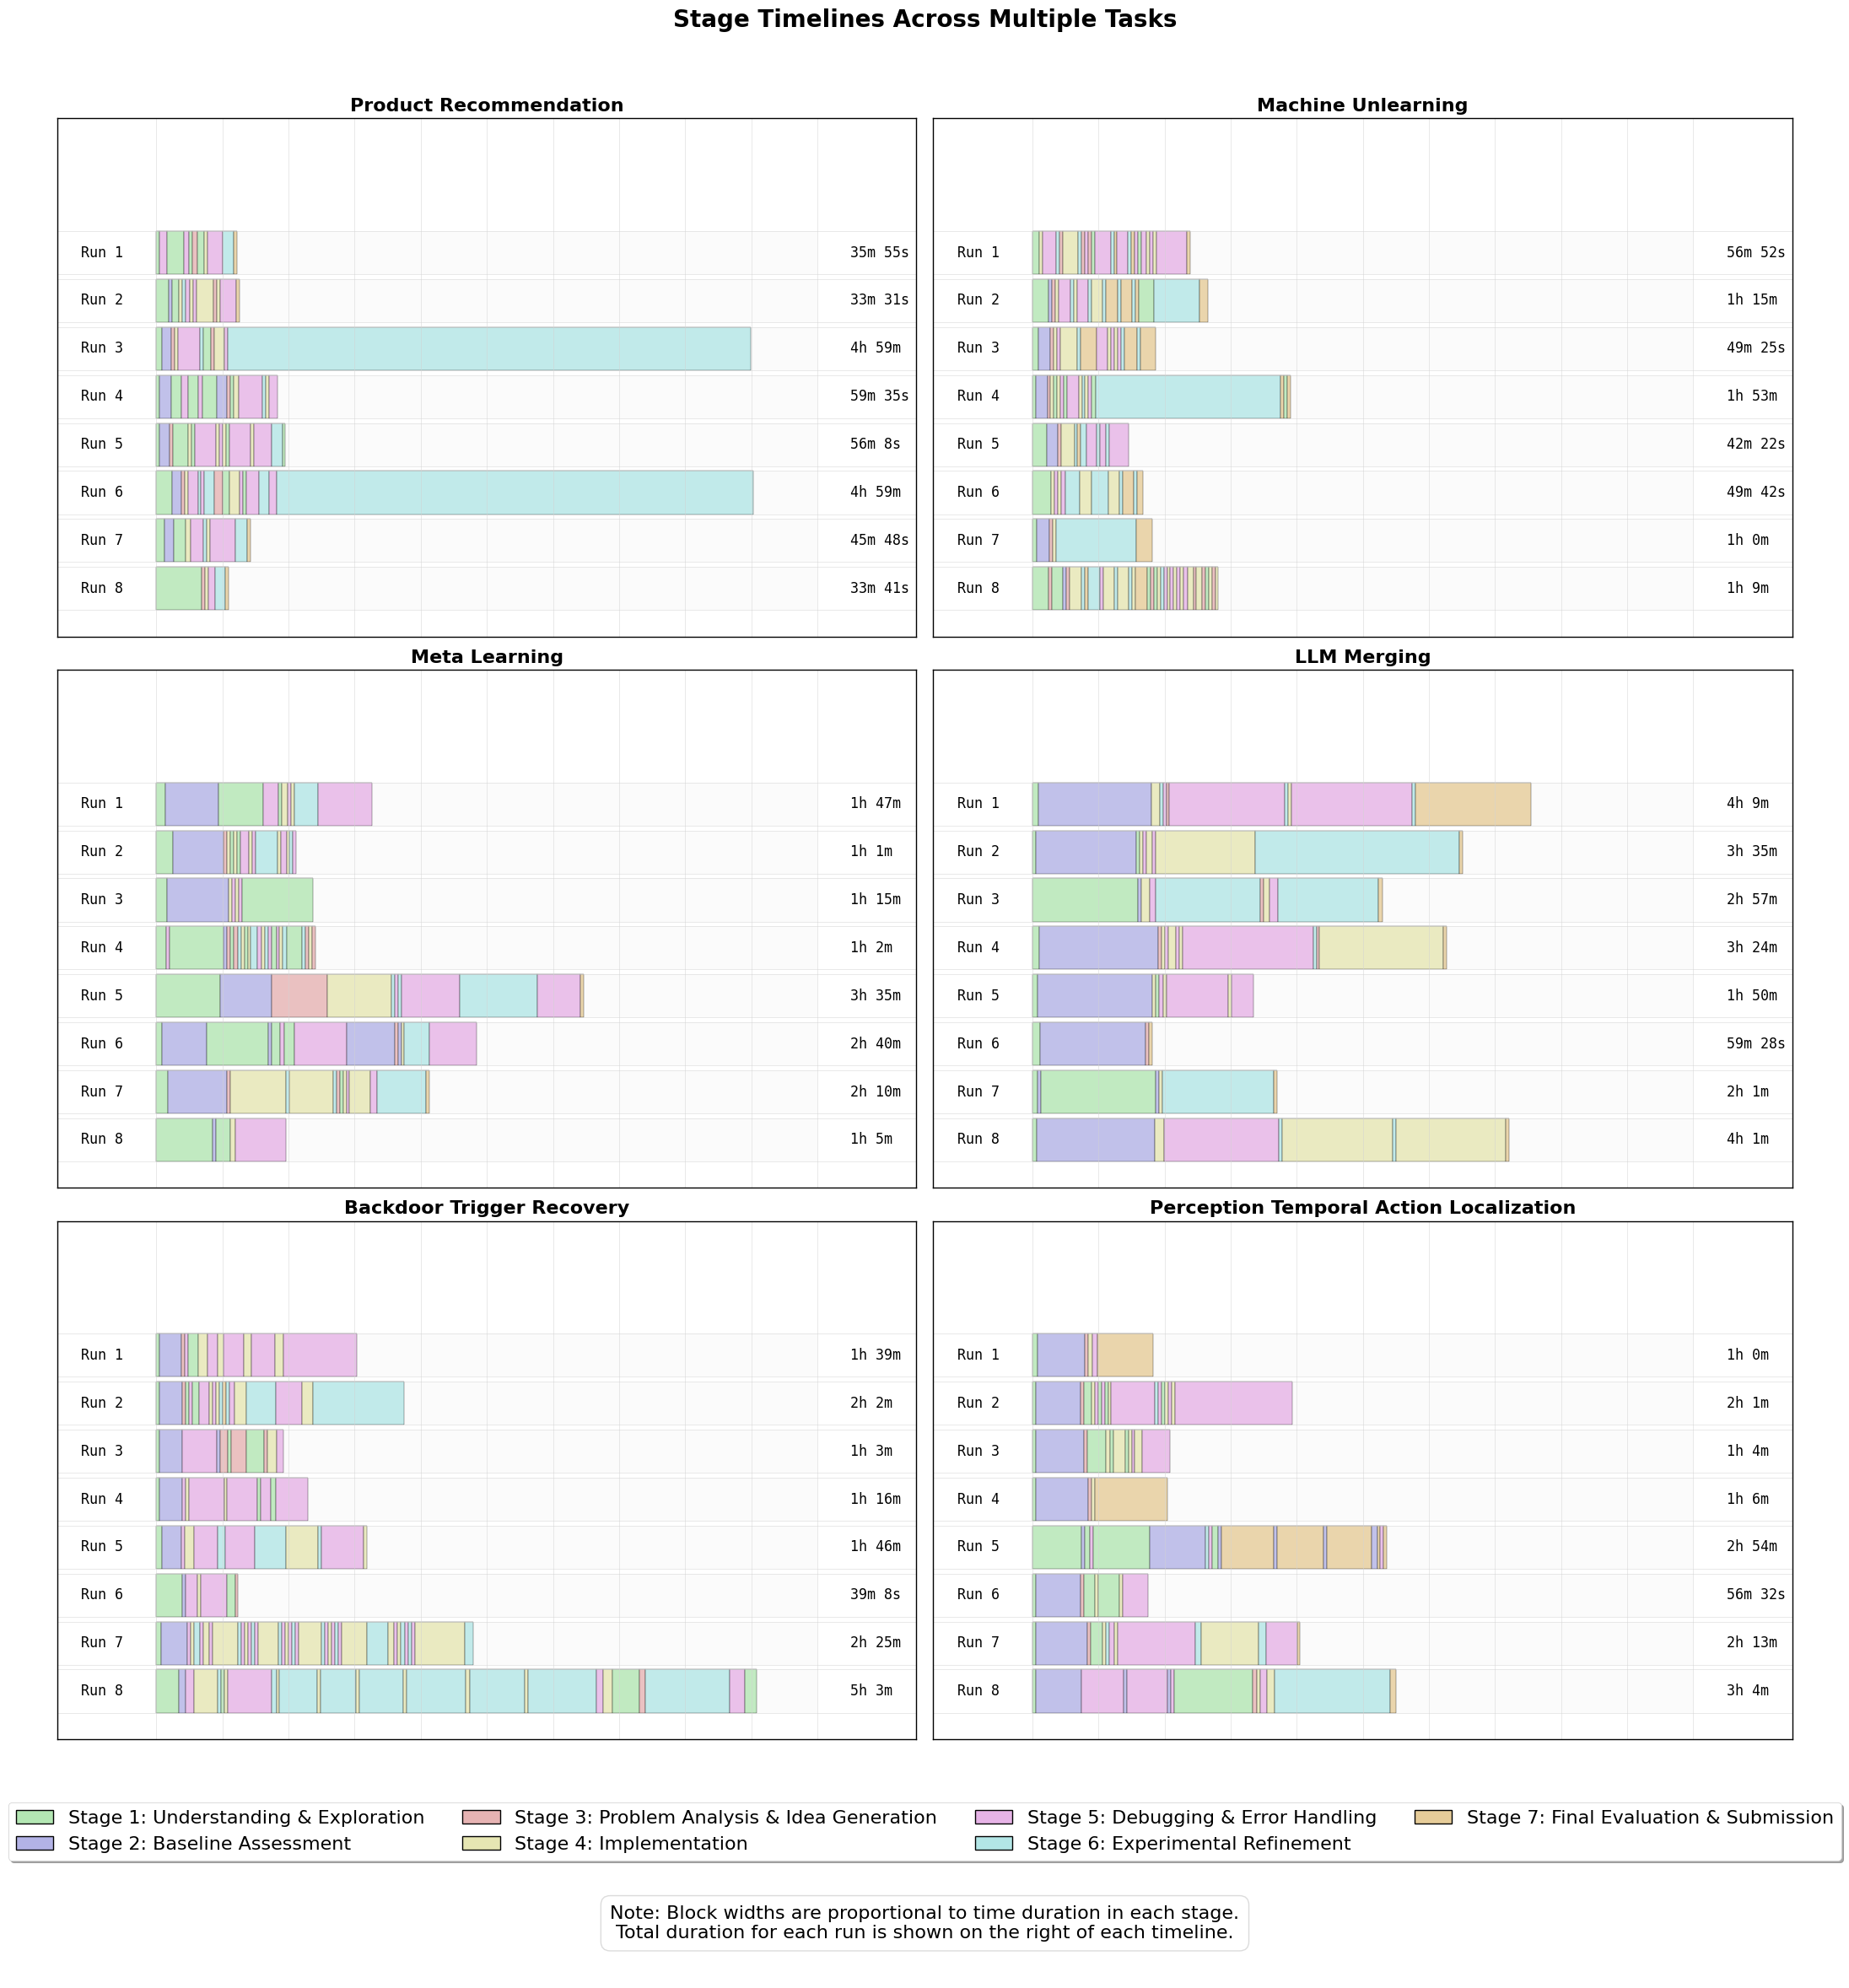

Generated combined timeline grid at Steps/combined_task_timelines.pdf


<Figure size 640x480 with 0 Axes>

In [25]:
custom_titles = {
    "machine_unlearning": "Machine Unlearning",
    "llm-merging": "LLM Merging",
    "backdoor-trigger-recovery": "Backdoor Trigger Recovery",
    "perception_temporal_action_loc": "Perception Temporal Action Localization",
    "product-recommendation": "Product Recommendation",
    "meta-learning": "Meta Learning"
    #"erasing_invisible_watermarks": "Erasing Invisible Watermarks",
    #"weather_forcast": "Rainfall Prediction"
    # Add more mappings as needed
}

# After processing all tasks in your main code
# Collect all task data in a dictionary
all_task_data = {}

# Root directory to search for analysis.json files
root_dir = 'Steps'

# Find all analysis.json files grouped by task
task_files = find_analysis_files(root_dir)

print(f"Found {sum(len(files) for files in task_files.values())} analysis.json files across {len(task_files)} tasks")

# Process each task
for task_name, file_paths in task_files.items():
    print(f"Processing task: {task_name} with {len(file_paths)} runs")
    
    # Process each run for this task
    run_data = []
    for file_path in file_paths:
        timeline_data = process_analysis_json(file_path)
        if timeline_data:
            run_data.append(timeline_data)
    
    # Generate a consolidated timeline for this task's runs
    if run_data:
        output_dir = os.path.join(root_dir, task_name)
        create_task_timeline(task_name, run_data, output_dir)
        
        # Store the run data for the combined grid
        all_task_data[task_name] = run_data
    else:
        print(f"No valid data found for task: {task_name}")

# Create the combined grid visualization
if all_task_data:
    create_combined_timeline_grid(all_task_data, root_dir, "combined_task_timelines.pdf", custom_titles)